In [31]:
import sys
import os
from os.path import split, join
base_dir = split(os.getcwd())[0]
if base_dir not in sys.path:
    sys.path.append(base_dir)
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt

from stats_tools.as_toolbox import std_to_prob
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
import importlib
import run_test
importlib.reload(run_test)

<module 'run_test' from 'c:\\Users\\kiril\\Thesis\\CoBra\\cobra\\t1_long\\run_test.py'>

In [3]:
data_dir = join(base_dir, 'data')
data_long_dir = join(data_dir, 't1_longitudinal')

In [37]:
pred_df = pd.read_feather(join(data_long_dir, 'results', 'volume_prediction_results.feather'))
pred_df.InstanceCreationDate = pd.to_datetime(pred_df.InstanceCreationDate, format='%Y-%m-%d')
with open(join(data_long_dir, 'final', 'affected_brain_regions_dic.pkl'), 'rb') as f:
    affected_br_dic = pickle.load(f)
brain_regions_ls = [item for sublist in list(affected_br_dic.values()) for item in sublist]
with open(join(data_long_dir, 'final', 'long_sids_pairs.pkl'), 'rb') as f:
    long_sids_pairs = pickle.load(f)
with open(join(data_long_dir, 'final', 'cc_dic_ps_optmatch_const10.pkl'), 'rb') as f:
    cc_dic_ps10 = pickle.load(f)
brain_regions_ls.insert(0,'Whole_Brain')

In [38]:
df_dV, pred_df_f = run_test.get_dV_df(brain_regions_ls, long_sids_pairs, cc_dic_ps10, pred_df)
df_dV.head(3)

,PatientID,Date_diff,Whole_Brain,Right_Central_Operculum,Left_Central_Operculum,Right_Anterior_Insula,Right_Posterior_Insula,Left_Anterior_Insula,Left_Posterior_Insula,Right_Hippocampus,...,Right_Temporal_Pole,Left_Temporal_Pole,Right_Anterior_Orbital_Gyrus,Right_Lateral_Orbital_Gyrus,Right_Medial_Orbital_Gyrus,Right_Posterior_Orbital_Gyrus,Left_Anterior_Orbital_Gyrus,Left_Lateral_Orbital_Gyrus,Left_Medial_Orbital_Gyrus,Left_Posterior_Orbital_Gyrus
0,00e520dd9e4c7f2b7798263bd0916221,101,-0.190614,0.124988,0.034193,0.054111,-0.334287,0.093935,0.092807,0.412025,...,-0.544165,-0.438485,-0.353982,0.079901,0.014829,0.100974,-0.355466,-0.544583,0.095302,0.332710
1,00fa9b0bcf1d122b848d9ac4b52c9e40,213,-0.005787,0.252917,0.170099,-0.155423,0.139785,0.033017,0.076063,-0.111458,...,-0.370000,-0.051034,-0.177066,-0.133335,0.153542,-0.354688,-0.117621,-0.160430,0.282845,0.185857
2,02ef1afb3ae8de0e82a5b78fc3b73163,189,-0.075497,0.099196,0.038676,0.111402,-0.041562,0.131057,0.136172,0.117708,...,-0.107745,-0.201195,-0.230634,0.002506,-0.042915,0.100810,-0.121000,-0.154462,0.004808,-0.027749


In [40]:
#sns.histplot(df_dV.Date_diff)

## Visualize differences

(-6.0, 20.0)

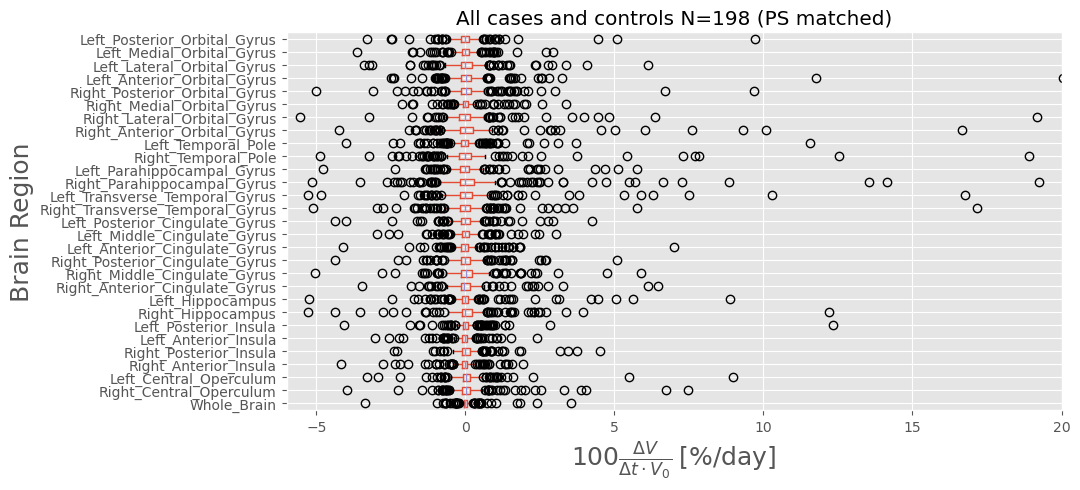

In [43]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize=(10,5))
plt.style.use('ggplot')
df_dV[brain_regions_ls].boxplot(vert=False,ax=ax)
ax.set_ylabel('Brain Region', fontsize=18)
ax.set_xlabel(r'$100\frac{\Delta V}{\Delta t\cdot V_0}\:[\%/{\mathrm{day}}]$', fontsize=18)
ax.set_title('All cases and controls N=198 (PS matched)')
ax.set_xlim(-6,20)

## Look at some of the outliers

In [44]:
LPOG_pats = df_dV[np.abs(stats.zscore(df_dV.Left_Posterior_Orbital_Gyrus)) > 3].PatientID.unique()

In [49]:
pred_df_f[pred_df_f.PatientID.isin(LPOG_pats)]

,SeriesInstanceUID,PatientID,InstanceCreationDate,newID,External_CSF,Third_Ventricle,Right_Inferior_Lateral_Ventricle,Right_Lateral_Ventricle,Left_Inferior_Lateral_Ventricle,Left_Lateral_Ventricle,...,Right_Cerebellum_Exterior,Right_Cerebellum_White_Matter,Left_Cerebellum_Exterior,Left_Cerebellum_White_Matter,Cerebellar_Vermal_Lobules_I_V,Cerebellar_Vermal_Lobules_VI_VII,Cerebellar_Vermal_Lobules_VIII_X,Background,Whole_Brain,Date_diff
1658,bb8b794033277df37a1cffe36081d7f9,d3629de9b9b95fb9238151b1315c1570,2019-12-10,078076,0,409,0,10491,9,16239,...,659,22,24,0,0,0,0,16387344,389872,19 days
1664,fe334ebff22ebca492e323f8b8f95993,d3629de9b9b95fb9238151b1315c1570,2019-11-21,078082,539,2621,2431,48567,2399,51900,...,44533,11223,43162,10264,677,164,88,15703620,1073596,0 days
3822,8af0cce5c740c66b6557fee0c9f00d02,5cde9fabf8bbf4fc3c143f2c48894148,2019-04-12,171876,237,1098,265,6683,43,3120,...,33559,2753,24363,1052,0,0,0,15970144,807072,0 days
3823,094bc2a2d85445f2f70ea3ab793efa38,5cde9fabf8bbf4fc3c143f2c48894148,2019-04-25,171885,731,939,292,10824,333,7874,...,40933,6046,33681,6247,910,4,0,15597547,1179669,13 days
4275,be8f3a8bf83045bdd01117027369d123,ef5518f0a762fe647075e3dcf148a9ff,2019-04-11,187206,556,1584,849,29282,405,31245,...,45985,13234,45734,12355,1128,107,2,15703774,1073442,7 days
4278,0c9cdc7e705364ee53b7934c42e25584,ef5518f0a762fe647075e3dcf148a9ff,2019-04-04,187212,481,1721,1496,30766,1153,33851,...,30777,7176,33638,6856,34,0,0,15825076,952140,0 days
5274,601b0997d2577cbc11463ed61eec7cce,5c09f85769967ed1c76ea85a461674df,2019-06-08,225658,860,1516,804,29847,742,38129,...,57335,14378,59836,13680,64,0,0,15587436,1189780,0 days
5816,c5c747e3e1f69a230bf6eeba71887d48,5c09f85769967ed1c76ea85a461674df,2019-07-05,249478,749,1349,544,28773,687,35741,...,61649,14160,63433,14544,0,0,0,15521436,1255780,27 days


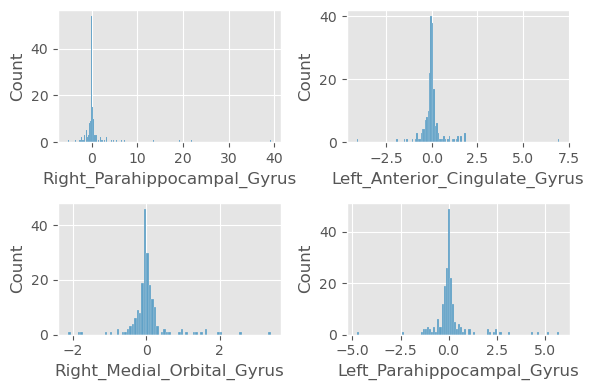

In [483]:
fig, ax = plt.subplots(2,2)
mpl.rcParams['figure.dpi'] = 100
ax = ax.flatten()
sns.histplot(df_dV.Right_Parahippocampal_Gyrus,ax=ax[0])
sns.histplot(df_dV.Left_Anterior_Cingulate_Gyrus,ax=ax[1])
sns.histplot(df_dV.Right_Medial_Orbital_Gyrus, ax=ax[2])
sns.histplot(df_dV.Left_Parahippocampal_Gyrus, ax=ax[3])

fig.tight_layout()

In [469]:
#pval_dic = compute_unadj_pvals(df_dV, cc_dic_ps10, brain_regions_ls)
#pval_dic

{'Right_Central_Operculum': 0.27173494168996526,
 'Left_Central_Operculum': 0.05450889328202235,
 'Right_Anterior_Insula': 0.2970597865149812,
 'Right_Posterior_Insula': 0.0009648057726658887,
 'Left_Anterior_Insula': 0.20514633329922605,
 'Left_Posterior_Insula': 0.08788351941504013,
 'Right_Hippocampus': 0.44730596123729405,
 'Left_Hippocampus': 0.20514633329922605,
 'Right_Anterior_Cingulate_Gyrus': 0.20514633329922605,
 'Right_Middle_Cingulate_Gyrus': 0.12281299384450661,
 'Right_Posterior_Cingulate_Gyrus': 0.1859624380178101,
 'Left_Anterior_Cingulate_Gyrus': 0.11009648434295105,
 'Left_Middle_Cingulate_Gyrus': 0.3524727453601255,
 'Left_Posterior_Cingulate_Gyrus': 0.07825552864928176,
 'Right_Transverse_Temporal_Gyrus': 0.003375011520096005,
 'Left_Transverse_Temporal_Gyrus': 0.20514633329922605,
 'Right_Parahippocampal_Gyrus': 0.3524727453601255,
 'Left_Parahippocampal_Gyrus': 0.3524727453601255,
 'Right_Temporal_Pole': 0.1859624380178101,
 'Left_Temporal_Pole': 0.15179792223956